In [1]:
import numpy as np
import matplotlib.pyplot as plt
import properscoring as ps
import pyreadr
from isodisreg import idr
import pandas as pd
from scipy.integrate import quad
import scipy as sc
from matplotlib.patches import Ellipse

In [2]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, (1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [3]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

In [4]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [5]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

In [6]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    #print(f"MAE: {np.round(mae,2)}")
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")
    
    #print(f"Bias: {np.round(bias,2)}")

In [7]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

# Interval score

In [37]:
exp = "exp_6"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'

In [63]:
# 0 - Brown, 1 - Powexp, 2 - Whitmat
model = 1

In [64]:
test_predictions = np.load(result_path+f"cnn_interval_all_test.npy")
test_parameters = np.load(data_path+f"test_params.npy")

#test_predictions = test_predictions[:,(model)*500:(model+1)*500]
#test_parameters = test_parameters[test_parameters[:,2] == model]

test_samples = test_parameters.shape[0]

## Computed scores and coverage

In [65]:
r_lower = test_predictions[0,:,0]
r_upper = test_predictions[1,:,0]
s_lower = test_predictions[0,:,1]
s_upper = test_predictions[1,:,1]

In [66]:
r_coverage = np.sum((test_parameters[:,0] >= r_lower) & ((test_parameters[:,0] <= r_upper)))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= s_lower) & ((test_parameters[:,1] <= s_upper)))/test_samples*100

In [67]:
alpha = 0.1
r_is, _, _ = interval_score(test_parameters[:,0], alpha, r_lower, r_upper)
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], alpha, s_lower, s_upper)
s_is = np.mean(s_is)

In [68]:
r_upper.max()

10.528166770935059

In [69]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: 1
Coverage 67.00%, 81.73% 
IS: 9.9822, 1.9357


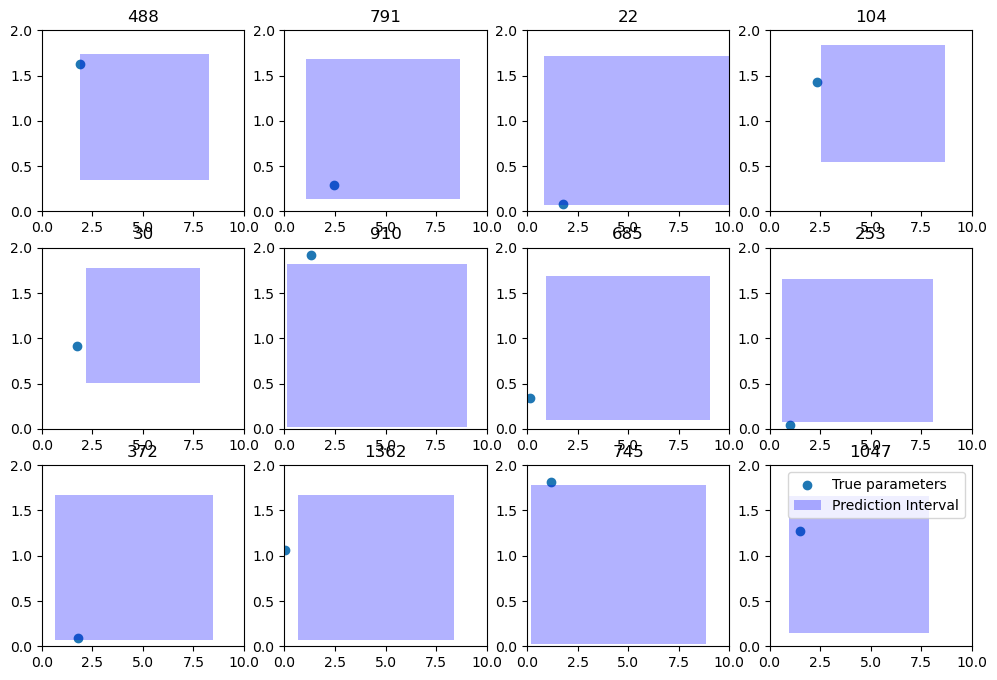

In [74]:
samples = np.random.randint(0,test_samples,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    #axs[x].scatter(prediction[i,0], prediction[i,1], marker = "x", label = "Prediction")
    
    anchor = (test_predictions[0,i,0], test_predictions[0,i,1])
    rectangle = plt.Rectangle(anchor, (test_predictions[1,i,0]-test_predictions[0,i,0]), (test_predictions[1,i,1]-test_predictions[0,i,1]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,10)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction Interval"])